# DPOY Award Prediction

## Data Preprocessing

Import general preprocessed data

In [1]:
%run Preprocessing_main.ipynb

In [2]:
DPOY_data['G_x'] = DPOY_data['G_x'].astype(int)

Dropping redundant columns (columns having correlation over 90%)

In [3]:
def drop_col(data):
    corr = data.corr()
    NEW_data = data
    del_list = []
    del_col = []
    for i in corr:
        for ind in corr[(corr[i]>0.9)&(corr[i]<1)].index:
            if ind not in del_list:
                try:
                    NEW_data = NEW_data.drop(ind, axis = 1)
                    del_col.append(ind)
                except:
                    continue
        del_list.append(i)
    NEW_data = NEW_data.drop('Player', axis = 1)
    return NEW_data, del_col

In [4]:
NEW_data, del_list = drop_col(DPOY_data)

### Standardize for analysis

In [5]:
# standardize through years
def std_scale_split(data, year_names):
    scaler = StandardScaler()
    X_train_result = pd.DataFrame()
    X_test_result = pd.DataFrame()
    y_train_result = pd.DataFrame()
    y_test_result = pd.DataFrame()
    for i in year_names:
        
        data_year = data[data['year_y']==i]
        data_year = data_year.drop(columns='year_y')
        
        X = data_year.iloc[:, :-1]
        y = data_year.iloc[:, -1]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
        train_scaled = scaler.fit_transform(X_train)
        test_scaled = scaler.transform(X_test)
        
        X_train_result = pd.concat([X_train_result, pd.DataFrame(train_scaled)])
        X_test_result = pd.concat([X_test_result, pd.DataFrame(test_scaled)])
        y_train_result = pd.concat([y_train_result, y_train])
        y_test_result = pd.concat([y_test_result, y_test])
        
    return X_train_result, X_test_result, y_train_result, y_test_result

X_train, X_test, y_train, y_test = std_scale_split(NEW_data, year_names)

## Model Implementation

### Model 1 : Linear Regression

In [6]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

regressionSummary(y_train, y_train_pred)
regressionSummary(y_test, y_pred)
lin_mse = mean_squared_error(y_test, y_pred)
comp = pd.DataFrame({0: y_test[0], 1: y_pred.reshape(len(y_pred))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_lin = y_pred_sorted


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.1664
            Mean Absolute Error (MAE) : 0.1186
          Mean Percentage Error (MPE) : -534.6338
Mean Absolute Percentage Error (MAPE) : 1202.6080

Regression statistics

                      Mean Error (ME) : -0.0685
       Root Mean Squared Error (RMSE) : 0.1746
            Mean Absolute Error (MAE) : 0.1274
          Mean Percentage Error (MPE) : -864.1461
Mean Absolute Percentage Error (MAPE) : 1515.2021


In [7]:
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
lin_cor = cor[1, 0]

### Model 2 : Support Vector Regression

In [8]:
regressor = SVR()
regressor.fit(X = X_train, y = y_train)
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
regressionSummary(y_train, y_train_pred)
regressionSummary(y_test, y_pred)
SVR_mse = mean_squared_error(y_test, y_pred)
comp = pd.DataFrame({0: y_test[0], 1: y_pred.reshape(len(y_pred))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_SVR = y_pred_sorted


Regression statistics

                      Mean Error (ME) : -0.0220
       Root Mean Squared Error (RMSE) : 0.0948
            Mean Absolute Error (MAE) : 0.0766
          Mean Percentage Error (MPE) : -723.8023
Mean Absolute Percentage Error (MAPE) : 975.7261

Regression statistics

                      Mean Error (ME) : -0.0692
       Root Mean Squared Error (RMSE) : 0.1424
            Mean Absolute Error (MAE) : 0.1031
          Mean Percentage Error (MPE) : -1083.5580
Mean Absolute Percentage Error (MAPE) : 1229.5596


In [9]:
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
SVR_cor = cor[1, 0]

### Model 3 : Decision Tree Regression

In [10]:
fin_alpha = 0
min_mse = 1E20
fin_cor = -1
for alpha in np.linspace(0, 0.5, 21):
    regressor = DecisionTreeRegressor(ccp_alpha = alpha, random_state = 1)
    regressor.fit(X = X_train, y = np.array(y_train).reshape(len(y_train), ))
    y_pred = regressor.predict(X_test)
    y_train_pred = regressor.predict(X_train)
    MSE = mean_squared_error(y_test, y_pred)
    cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
    if cor[1, 0] > fin_cor:
        fin_alpha = alpha
        fin_cor = cor[1, 0]
        y_pred_tree = y_pred
print('alpha: {:1.4f}, CORR: {:1.4f}'.format(fin_alpha, fin_cor))
tree_cor = fin_cor
comp = pd.DataFrame({0: y_test[0], 1: y_pred_tree.reshape(len(y_pred_tree))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_tree = y_pred_sorted

alpha: 0.0000, CORR: 0.3271


### Model 4 : Random Forest Regression

In [11]:
min_mse = 1E20
fin_alpha = 0
fin_NE = 0
fin_cor = -1

for alpha in np.linspace(0, 0.5, 11):
    for n_e  in np.linspace(10, 100, 10):
        regressor = RandomForestRegressor(n_estimators = int(n_e), ccp_alpha = alpha, random_state = 1)
        regressor.fit(X = X_train, y = np.array(y_train).reshape(len(y_train), ))
        y_pred = regressor.predict(X_test)
        y_train_pred = regressor.predict(X_train)
        MSE = mean_squared_error(y_test, y_pred)
        cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
        if cor[1, 0] > fin_cor:
            fin_alpha = alpha
            fin_cor = cor[1, 0]
            fin_NE = n_e
            y_pred_for = y_pred
            
print('alpha: {:1.4f}, N_estimator: {} CORR: {:1.4f}'.format(fin_alpha, fin_NE, fin_cor))
for_cor = fin_cor
comp = pd.DataFrame({0: y_test[0], 1: y_pred_for.reshape(len(y_pred_for))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_for = y_pred_sorted

alpha: 0.0000, N_estimator: 100.0 CORR: 0.3815


### Model 5 : Neural Network

Scaling data into [0, 1] for neural network

In [12]:
# minmax scale through years
def nor_scale_split(data, year_names):
    scaler = MinMaxScaler()

    X_train_result = pd.DataFrame()
    X_test_result = pd.DataFrame()
    y_train_result = pd.DataFrame()
    y_test_result = pd.DataFrame()
    for i in year_names:
        
        data_year = data[data['year_y']==i]
        data_year = data_year.drop(columns='year_y')
        
        X = data_year.iloc[:, :-1]
        y = data_year.iloc[:, -1]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
        train_scaled = scaler.fit_transform(X_train)
        test_scaled = scaler.transform(X_test)
        
        X_train_result = pd.concat([X_train_result, pd.DataFrame(train_scaled)])
        X_test_result = pd.concat([X_test_result, pd.DataFrame(test_scaled)])
        y_train_result = pd.concat([y_train_result, y_train])
        y_test_result = pd.concat([y_test_result, y_test])
        
    return X_train_result, X_test_result, y_train_result, y_test_result

X_train, X_test, y_train, y_test = nor_scale_split(NEW_data, year_names)

In [13]:
best_cor = 0
best_bat = [0, 0]
best_size = [0, 0]
for size1 in [int(i) for i in np.linspace(5, 20, 16)]:
    for bat in [int(i) for i in np.linspace(0, 100, 21)]:
        NNRegressor = MLPRegressor(hidden_layer_sizes = (size1), batch_size = bat, 
                                   activation = 'logistic', random_state= 1)
        NNRegressor.fit(X_train, y_train)
        y_pred = NNRegressor.predict(X_test)
        NN_cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
        NN_cor = NN_cor[1, 0]
        if NN_cor > best_cor:
            best_cor = NN_cor
            best_size[0] = size1
            best_bat[0] = bat
            y_pred_NN = y_pred
print('layer size: {:1.4f}, batch size: {:1.4f}, CORR: {:1.4f}'.format(best_size[0], best_bat[0], best_cor))
NN_cor = best_cor
comp = pd.DataFrame({0: y_test[0], 1: y_pred_NN.reshape(len(y_pred_NN))})
y_pred_sorted = comp.sort_values(1, ascending=False)[0]
y_pred_NN = y_pred_sorted

layer size: 10.0000, batch size: 65.0000, CORR: 0.5252


### Model Comparison Using Correlation Coefficient and Lift Chart

In [14]:
print('Linear regression: {:1.4f}'.format(lin_cor))
print('SVR: {:1.4f}'.format(SVR_cor))
print('Decision tree: {:1.4f}'.format(tree_cor))
print('Random forest: {:1.4f}'.format(for_cor))
print('Neural Network: {:1.4f}'.format(NN_cor))

Linear regression: 0.3733
SVR: 0.4674
Decision tree: 0.3271
Random forest: 0.3815
Neural Network: 0.5252


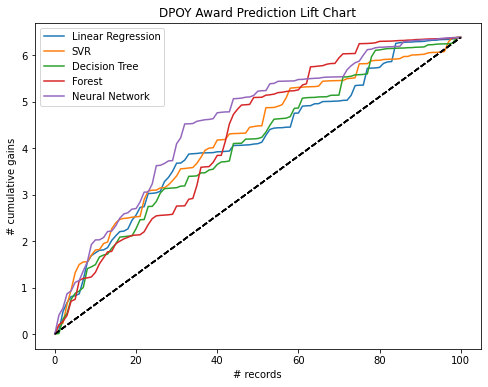

In [15]:
ax = gainsChart(pd.Series(y_pred_lin), label = 'Linear Regression',figsize = [8, 6], color = 'C0')
ax = gainsChart(pd.Series(y_pred_SVR), label = 'SVR', ax = ax, color = 'C1')
ax = gainsChart(pd.Series(y_pred_tree), label = 'Decision Tree', ax = ax, color = 'C2')
ax = gainsChart(pd.Series(y_pred_for), label = 'Forest', ax = ax, color = 'C3')
ax = gainsChart(pd.Series(y_pred_NN), label = 'Neural Network', ax = ax, color = 'C4')
plt.title('DPOY Award Prediction Lift Chart')
plt.legend()
plt.show()

# Evaluation

## Random Forest Regression

### Summary

In [16]:
# preprocessing
X_train, X_test, y_train, y_test = std_scale_split(NEW_data, year_names)

# build model
regressor = RandomForestRegressor(n_estimators = 100, ccp_alpha = 0, random_state = 1)
regressor.fit(X_train, y_train)

# model summary
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

print('Model: Random Forest Regression\n')
regressionSummary(y_test, y_pred)

# evaluations
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
for_cor = cor[1, 0]

for_RMSE = mean_squared_error(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))**0.5
print('\nCORR: {:1.4f}'.format(for_cor))
print('RMSE: {:1.4f}'.format(for_RMSE))

Model: Random Forest Regression


Regression statistics

                      Mean Error (ME) : -0.0663
       Root Mean Squared Error (RMSE) : 0.1479
            Mean Absolute Error (MAE) : 0.1014
          Mean Percentage Error (MPE) : -821.1308
Mean Absolute Percentage Error (MAPE) : 837.2573

CORR: 0.3815
RMSE: 0.1479


### Visualization

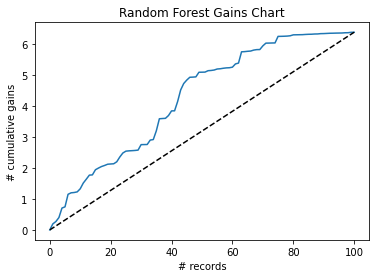

In [17]:
ax = gainsChart(pd.Series(y_pred_for), label = 'Random Forest')
plt.title('Random Forest Gains Chart')
plt.show()

### Prediction

In [18]:
data_2022['G_x'] = data_2022['G_x'].astype(int)
NEW_2022 = data_2022.drop(del_list, axis = 1)
NEW_2022 = NEW_2022.drop('Rk', axis = 1)
player_list = NEW_2022['Player']
NEW_2022 = NEW_2022.drop('Player', axis = 1)

In [19]:
scaler = StandardScaler()
scaled_2022 = scaler.fit_transform(NEW_2022)
pred_22_for = regressor.predict(scaled_2022)

## Neural network

In [20]:
# preprocessing
X_train, X_test, y_train, y_test = nor_scale_split(NEW_data, year_names)

# build model
NN = MLPRegressor(hidden_layer_sizes = (10), batch_size = 65, 
                                   activation = 'logistic', random_state= 1)
NN.fit(X_train, y_train)

# model summary
y_pred = NN.predict(X_test)
y_train_pred = NN.predict(X_train)

print('Model: Neural network\n')
regressionSummary(y_test, y_pred)

# evaluations
cor = np.corrcoef(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))
NN_cor = cor[1, 0]

NN_R2 = r2_score(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))

NN_RMSE = mean_squared_error(np.array(y_test).reshape(len(y_test)), np.array(y_pred).reshape(len(y_pred)))**0.5
print('\nCORR: {:1.4f}'.format(NN_cor))
print('RMSE: {:1.4f}'.format(NN_RMSE))

Model: Neural network


Regression statistics

                      Mean Error (ME) : -0.0320
       Root Mean Squared Error (RMSE) : 0.0895
            Mean Absolute Error (MAE) : 0.0713
          Mean Percentage Error (MPE) : -885.8196
Mean Absolute Percentage Error (MAPE) : 996.8723

CORR: 0.5252
RMSE: 0.0895


### Visualization

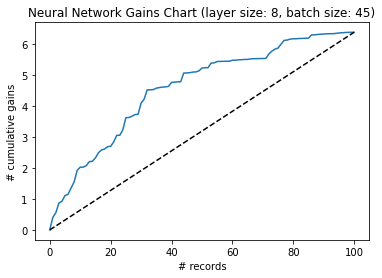

In [21]:
ax = gainsChart(pd.Series(y_pred_NN), label = 'Neural Network')
plt.title('Neural Network Gains Chart (layer size: 8, batch size: 45)')
plt.show()

### Prediction

In [22]:
scaler = MinMaxScaler()
scaled_2022 = scaler.fit_transform(NEW_2022)
pred_22_NN = NN.predict(scaled_2022)

# Prediction Results

In [23]:
NEW_2022['Player'] = player_list
NEW_2022['share_NN'] = pred_22_NN
NEW_2022['share_for'] = pred_22_for

#### Neural Network prediction

In [24]:
NEW_2022.sort_values('share_NN', ascending=False).head(5)[['Player', 'share_NN']]

,Player,share_NN
455,Rudy Gobert\goberru01,0.232049
715,Nikola Jokić\jokicni01,0.225346
344,Joel Embiid\embiijo01,0.224206
27,Giannis Antetokounmpo\antetgi01,0.217340
1350,Karl-Anthony Towns\townska01,0.177079


#### Random Forest Prediction

In [25]:
NEW_2022.sort_values('share_for', ascending=False).head(5)[['Player', 'share_for']]

,Player,share_for
455,Rudy Gobert\goberru01,0.73924
344,Joel Embiid\embiijo01,0.63750
715,Nikola Jokić\jokicni01,0.60798
2,Bam Adebayo\adebaba01,0.57872
15,Jarrett Allen\allenja01,0.57140
